# Part of Speech Tagging with Hidden Markov Models 
---

Part of Speech Tagging (POS) is helpful to disambiguate natural language phrases because it can be done quickly with high accuracy and used for a variety of tasks: determining correct pronunciation during speech synthesis (_dis_-count noun vs dis-_count_ verb), for IR, word sense disambiguation.

This notebook uses the [Pomegranate](http://pomegranate.readthedocs.io/) library to build a hidden Markov model (HMM) on the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) (originally from the [NLTK](https://www.nltk.org/) library) using a simiplified [universal tagset](https://arxiv.org/pdf/1104.2086.pdf) which provides a slightly higher accuracy compared with a larger tagset like the full [Penn treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html), but the process is the same for any tagset.

HMMs have also been used for speech recognition / generation, machine translation, gene recognition, and human gesture recognition, and more. 

![](_post-hmm.png)

In [1]:
%load_ext autoreload
%aimport helpers, tests
%autoreload 1

import matplotlib.pyplot as plt
import numpy as np

from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Step 1: Read and preprocess data 
---

Dataset - each sentence starts with a unique identifier on the first line, followed by one tab-separated word/tag pair on each following line. Sentences are separated by a single blank line.

### Dataset Class


```
Dataset-only Attributes:
    training_set - reference to a Subset object containing the samples for training
    testing_set - reference to a Subset object containing the samples for testing

Dataset & Subset Attributes:
    sentences - a dictionary of ALL sentences in the corpus, each keyed to a unique sentence identifier; each Sentence is itself an object with two attributes: a tuple of the words (named words) and a tuple of corresponding tags named tags
    keys - an immutable ordered (not sorted) collection of the sentence_keys for the corpus
    vocab - an immutable collection of the unique words in the corpus
    tagset - an immutable collection of the unique tags in the corpus
    X - returns an array of words grouped by sentences ((w11, w12, w13, ...), (w21, w22, w23, ...), ...)
    Y - returns an array of tags grouped by sentences ((t11, t12, t13, ...), (t21, t22, t23, ...), ...)
    N - returns the number of distinct samples (individual words or tags) in the dataset

Methods:
    stream() - returns an flat iterable over all (word, tag) pairs across all sentences in the corpus
    __iter__() - returns an iterable over the data as (sentence_key, Sentence()) pairs
    __len__() - returns the nubmer of sentences in the dataset
```

For example, consider a Subset, `subset`, of the sentences `{"s0": Sentence(("See", "Spot", "run"), ("VERB", "NOUN", "VERB")), "s1": Sentence(("Spot", "ran"), ("NOUN", "VERB"))}`. The subset will have these attributes:

```
subset.keys == {"s1", "s0"}  # unordered
subset.vocab == {"See", "run", "ran", "Spot"}  # unordered
subset.tagset == {"VERB", "NOUN"}  # unordered
subset.X == (("Spot", "ran"), ("See", "Spot", "run"))  # order matches .keys
subset.Y == (("NOUN", "VERB"), ("VERB", "NOUN", "VERB"))  # order matches .keys
subset.N == 7  # there are a total of seven observations over all sentences
len(subset) == 2  # because there are two sentences
```

The `Dataset` class is _convenient_, but it is **not** efficient. It is not suitable for huge datasets because it stores multiple redundant copies of the same data

In [2]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

assert len(data) == len(data.training_set) + len(data.testing_set), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


In [3]:
# example of a sentence
key = 'b100-38532'
print("Sentence: {}".format(key))
print("words:\n\t{!s}".format(data.sentences[key].words))
print("tags:\n\t{!s}".format(data.sentences[key].tags))

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


In [4]:
# list of unique words in Dataset.vocab and unique tags in Dataset.tagset
print("There are a total of {} samples of {} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

assert data.N == data.training_set.N + data.testing_set.N, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 928458 samples of 50536 unique words in the training set.
There are 232734 samples of 25112 unique words in the testing set.
There are 5521 words in the test set that are missing in the training set.


In [5]:
# Dataset.X and Dataset.Y are ordered collections of matching word and tag sequences for each sentence
for i in range(2):    
    print("Sentence {}:".format(i + 1), data.X[i])    
    print("Labels {}:".format(i + 1), data.Y[i])
    print()

Sentence 1: ('Mr.', 'Podger', 'had', 'thanked', 'him', 'gravely', ',', 'and', 'now', 'he', 'made', 'use', 'of', 'the', 'advice', '.')
Labels 1: ('NOUN', 'NOUN', 'VERB', 'VERB', 'PRON', 'ADV', '.', 'CONJ', 'ADV', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', '.')

Sentence 2: ('But', 'there', 'seemed', 'to', 'be', 'some', 'difference', 'of', 'opinion', 'as', 'to', 'how', 'far', 'the', 'board', 'should', 'go', ',', 'and', 'whose', 'advice', 'it', 'should', 'follow', '.')
Labels 2: ('CONJ', 'PRT', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADP', 'ADV', 'ADV', 'DET', 'NOUN', 'VERB', 'VERB', '.', 'CONJ', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', '.')



In [6]:
# Dataset.stream() = an iterator of pairs of (word, tag) entries for the entire corpus
print("\nStream (word, tag) pairs:\n")
for i, pair in enumerate(data.stream()):
    print("\t", pair)
    if i > 5: break


Stream (word, tag) pairs:

	 ('Mr.', 'NOUN')
	 ('Podger', 'NOUN')
	 ('had', 'VERB')
	 ('thanked', 'VERB')
	 ('him', 'PRON')
	 ('gravely', 'ADV')
	 (',', '.')


## Step 2: Most Frequent Class tagger
---

Assigns the most frequent tag to each word as a simplified option

In [7]:
def pair_counts(sequences_A, sequences_B):
        
    """Return a dictionary keyed to each unique value in the first sequence list that counts the number of occurrences of
    the corresponding value from the second sequences list. E.g. if sequences_A == tags, sequences_B == words,
    and if "time" is tagged as a NOUN 1244 times, then pair_counts[NOUN][time] == 1244
    """
    my_keys = set(list(sequences_A))
    res = dict()
    for item in my_keys:
        res[item] = dict()
    for item in zip(sequences_A, sequences_B):
        if item[1] not in res[item[0]]:
            res[item[0]][item[1]] = 0
        res[item[0]][item[1]] += 1
    return res

# prepare tags and corresponding words in the same order
tags, words = [], []
for i, pair in enumerate(data.stream()):
    words.append(pair[0])
    tags.append(pair[1])
    
# Calculate C(tag_i, word_i)
emission_counts = pair_counts(tags, words)
len(emission_counts)
emission_counts['NOUN']['time']# == 1244

1555

### IMPLEMENTATION: Most Frequent Class Tagger

Use the `pair_counts()` function and the training dataset to find the most frequent class label for each word in the training data, and populate the `mfc_table` below. The table keys should be words, and the values should be the appropriate tag string.

The `MFCTagger` class is provided to mock the interface of Pomegranite HMM models so that they can be used interchangeably.

In [8]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

# Mocks the Pomegranite HMM models so that both can be used interchangeably
class MFCTagger:
    
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
                
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
                
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# word_counts[pos][word] = frequency for training set only
tags, words = [], []
for i, pair in enumerate(data.training_set.stream()):
    words.append(pair[0])
    tags.append(pair[1])
word_counts = pair_counts(tags, words)

# get a list of (word, frequency, pos) tuples
triples = []
for pos, value in word_counts.items():
    for word, freq in value.items():
        triples.append((word, freq, pos))

# sort first by word, then by frequency in reverse order (to have top frequency first for the same word)       
triples = sorted(triples, key=lambda t: (t[0],t[1]), reverse=True)

# add {word: most freq pos} to mfc_table
mfc_table = dict()
for item in triples:
    if item[0] not in mfc_table:
        mfc_table[item[0]] = item[2]
                
mfc_model = MFCTagger(mfc_table)

In [9]:
# interface with Pomegranate models & MFCTagger
def replace_unknown(sequence):
        
    """Replace each unknown word string 'nan' (ignored by Pomegranate)"""
        
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
        
    """X should be a 1-D sequence of observations for the model to predict"""
        
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

In [10]:
# example decoding
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', 

In [11]:
def accuracy(X, Y, model):
        
    """Accuracy = compare decoded sequences in X with the true labels in Y.    
    X.shape[0] = num of sentences to test; each element of the array = an iterable of words in a sequence.
    X.shape = Y.shape    
    """
        
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        """The model.viterbi call in simplify_decoding will return None if the HMM
        raises an error (for example, if a test sentence contains a word that
        is out of vocabulary for the training set). Any exception counts the
        full sentence as an error (which makes this a conservative estimate)"""
                
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

In [12]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

training accuracy mfc_model: 95.72%
testing accuracy mfc_model: 93.00%


## Step 3: HMM tagger
---
The HMM tagger has one hidden state for each tag. It is parameterized by two distributions: **emission probabilties** = conditional probability of observing a given _word_ from each hidden state, and **transition probabilities** = conditional probability of moving between _tags_ during the sequence. The **starting probability distribution** (the probability of each _tag_ being the first tag in a sequence), and the **ending probability distribution** (the probability of each _tag_ being the last tag in a sequence) are also accounted for.

The maximum likelihood estimate of these distributions can be calculated from the frequency counts. The HMM model will make predictions according to the formula:

$$t_i^n = \underset{t_i^n}{\mathrm{argmax}} \prod_{i=1}^n P(w_i|t_i) P(t_i|t_{i-1})$$

Unigram probability of each tag (N = total num of input samples):

$$P(tag_1) = \frac{C(tag_1)}{N}$$

Bigram probability of two tags: $$P(tag_2|tag_1) = \frac{C(tag_2|tag_1)}{C(tag_2)}$$


#### Procedure
Using pos tag unigram and bigram counts:
- Add one state per tag
    - The emission distribution at each state should be estimated with the formula: $P(w|t) = \frac{C(t, w)}{C(t)}$
- Add an edge from the starting state `basic_model.start` to each tag
    - The transition probability should be estimated with the formula: $P(t|start) = \frac{C(start, t)}{C(start)}$
- Add an edge from each tag to the end state `basic_model.end`
    - The transition probability should be estimated with the formula: $P(end|t) = \frac{C(t, end)}{C(t)}$
- Add an edge between _every_ pair of tags
    - The transition probability should be estimated with the formula: $P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

In [13]:
# dict() of overall pos counts, e.g. tag_unigrams['NOUN'] = 10004
sequences = data.training_set.Y                                            # list of pos tag lists (1 list per sent)
sequences_flat = [element for tupl in sequences for element in tupl]       # flatten
tag_unigrams = dict(Counter(sequences_flat))

# dict() of pos bigram counts, e.g. tag_bigrams[('NOUN', 'VERB')] == 61592
sequences_bigram = list(zip(sequences_flat[:-1], sequences_flat[1:]))
tag_bigrams = dict(Counter(sequences_bigram))

# dict() of counts of pos in the sentence starting position
sequences_start = [tupl[0] for tupl in sequences]
tag_starts = dict(Counter(sequences_start))

# dict() of counts of pos in the sentence ending position
sequences_end = [tupl[-1] for tupl in sequences]
tag_ends = dict(Counter(sequences_end))

In [14]:
# emission_counts for training set
tags, words = [], []
for i, pair in enumerate(data.training_set.stream()):
    words.append(pair[0])
    tags.append(pair[1])
    
# Calculate C(tag_i, word_i)
emission_counts = pair_counts(tags, words)

# initialize model instance
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

In [15]:
# Add emission probability distributions P(word | tag) for each tag and store them in separate states by tag
states = []
for tag, words in emission_counts.items():
    total_count = len(words)
    dist  = {word: count/total_count for word, count in words.items()}
    tag_emissions = DiscreteDistribution(dist)
    tag_state = State(tag_emissions, name=tag)
    basic_model.add_states(tag_state)
    states.append(tag_state)

In [16]:
# Add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
total_sents = data.training_set.__len__()

# first for starting and ending positions
starts_prob = {tag: count / total_sents for (tag, count) in tag_starts.items()}
ends_prob   = {tag: count / total_sents for (tag, count) in tag_ends.items()}

for state in states:
    if state.name in starts_prob:
        basic_model.add_transition(basic_model.start, state, starts_prob[state.name])
    if state.name in ends_prob:
        basic_model.add_transition(state, basic_model.end, ends_prob[state.name])
    
# then between tags    
total_tag_pairs = sum([count for (tag, count) in tag_bigrams.items()])
tag_pair_prob   = {pair: count / total_tag_pairs for pair, count in tag_bigrams.items()}
for state in states:
    for state2 in states:
        pair = (state.name, state2.name)
        if pair in tag_pair_prob:
            basic_model.add_transition(state, state2, tag_pair_prob[pair])

In [17]:
# finalize the model
basic_model.bake()

In [18]:
# calculate train and test accuracies
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

training accuracy basic hmm model: 97.07%
testing accuracy basic hmm model: 95.52%


In [19]:
# example decoding
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', '.', 

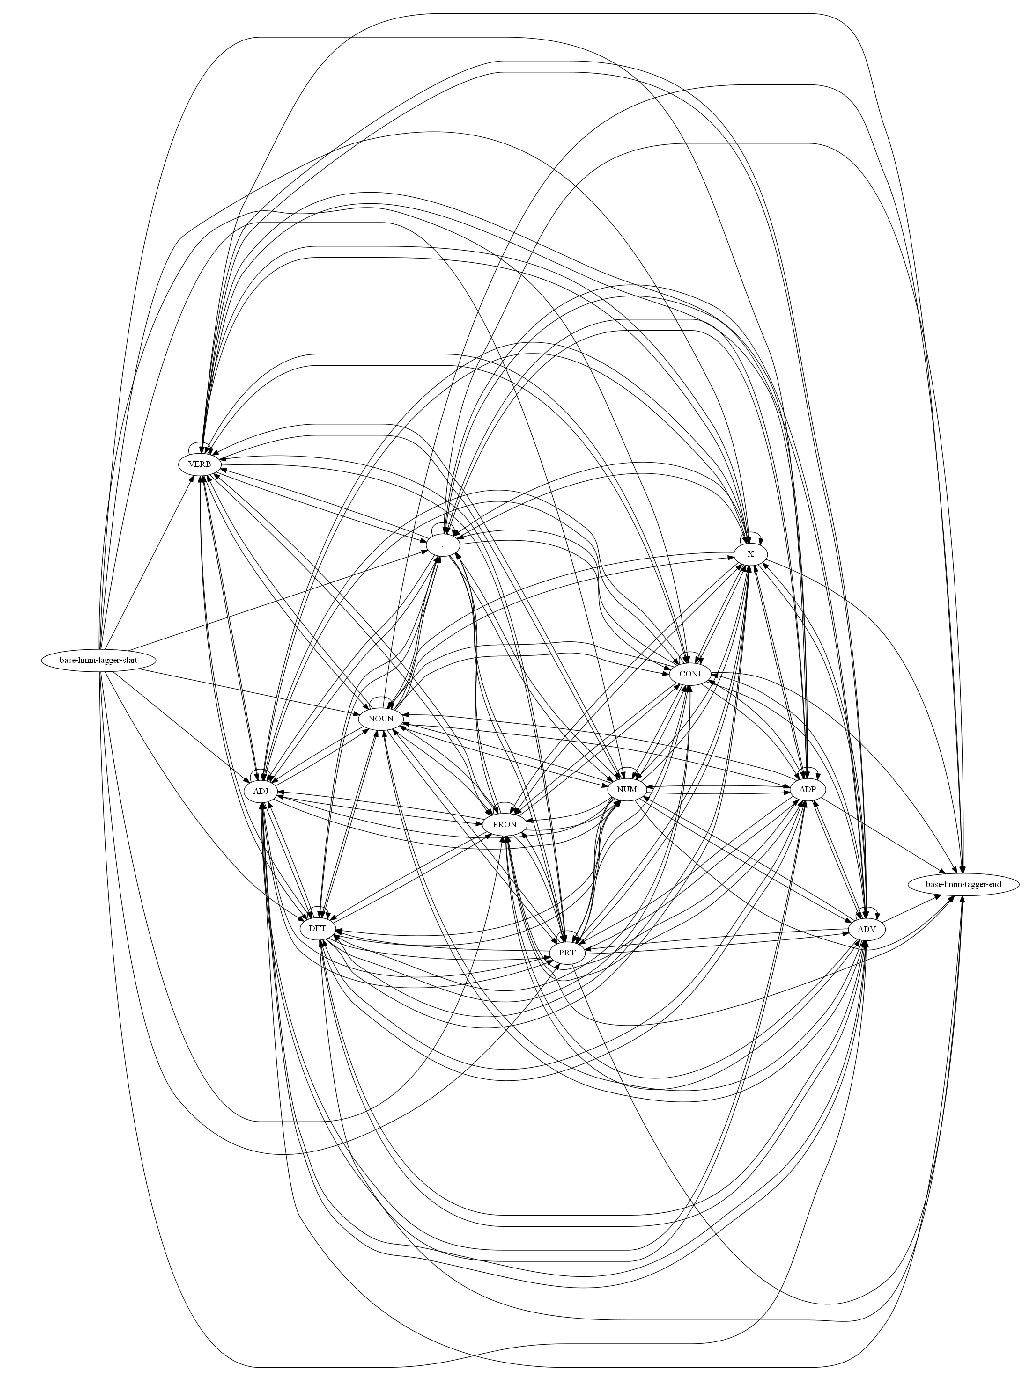

In [20]:
show_model(basic_model, figsize=(25, 25), filename="example.png", overwrite=True, show_ends=True)

## Step 4: Brown Corpus with a Larger (Original) Tagset 
---


In [21]:
import nltk
from nltk.corpus import brown

#nltk.download('brown')
#corpus = nltk.corpus.brown

In [22]:
# save Brown corpus sentences in the same format (to save time)
#with open('brown-original.txt', 'w') as f:
#    for idx, sent in enumerate(corpus.tagged_sents()):
#        f.write('b100-' + str(1000 + idx) + '\n')
#        for pair in sent:
#            f.write(pair[0] + '\t' + pair[1] + '\n')
#        f.write('\n')

In [23]:
# save original Brown corpus tags
#tags = set()
#for sent in corpus.tagged_sents():
#    tags.update([word[1] for word in sent])
#
#with open('tags-original.txt', 'w') as f:
#    for item in sorted(list(tags)):
#        f.write(item + '\n')

In [24]:
data = Dataset("tags-original.txt", "brown-original.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

assert len(data) == len(data.training_set) + len(data.testing_set), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


## Most Frequent Class tagger on original tag set

In [25]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

# Mocks the Pomegranite HMM models so that both can be used interchangeably
class MFCTagger:
    
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
                
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
                
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# word_counts[pos][word] = frequency for training set only
tags, words = [], []
for i, pair in enumerate(data.training_set.stream()):
    words.append(pair[0])
    tags.append(pair[1])
word_counts = pair_counts(tags, words)

# get a list of (word, frequency, pos) tuples
triples = []
for pos, value in word_counts.items():
    for word, freq in value.items():
        triples.append((word, freq, pos))

# sort first by word, then by frequency in reverse order (to have top frequency first for the same word)       
triples = sorted(triples, key=lambda t: (t[0],t[1]), reverse=True)

# add {word: most freq pos} to mfc_table
mfc_table = dict()
for item in triples:
    if item[0] not in mfc_table:
        mfc_table[item[0]] = item[2]
                
mfc_model = MFCTagger(mfc_table)

In [26]:
# interface with Pomegranate models & MFCTagger
def replace_unknown(sequence):
        
    """Replace each unknown word string 'nan' (ignored by Pomegranate)"""
        
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
        
    """X should be a 1-D sequence of observations for the model to predict"""
        
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

In [27]:
# example decoding
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-40378

Predicted labels:
-----------------
['CC', 'WDT', 'RB', 'MD', 'PPS', 'DO', '.', '.']

Actual labels:
--------------
('CC', 'WDT', 'RB', 'MD', 'PPS', 'DO', '.', '.')


Sentence Key: b100-36344

Predicted labels:
-----------------
['AP', 'IN', 'PPO', 'MD', 'VB', 'CS', 'IN', 'DT', 'NN', 'IN', 'AT', 'NN', 'IN', 'NNS', 'CC', 'AT', 'VBG', 'IN', 'VBG', 'EX', 'BEZ', 'PN', 'QL', 'JJ', '.']

Actual labels:
--------------
('AP', 'IN', 'PPO', 'MD', 'VB', 'CS', 'IN', 'DT', 'NN', 'IN', 'AT', 'NN', 'IN', 'NNS', 'CC', 'AT', 'NN', 'IN', 'VBG', 'EX', 'BEZ', 'PN', 'QL', 'JJ', '.')


Sentence Key: b100-39212

Predicted labels:
-----------------
['NP', 'VBD', ',', '``', 'DT+BEZ', 'ABN', 'JJ', '.']

Actual labels:
--------------
('NP', 'VBD', ',', '``', 'DT+BEZ', 'QL', 'JJ', '.')




In [28]:
def accuracy(X, Y, model):
        
    """Accuracy = compare decoded sequences in X with the true labels in Y.    
    X.shape[0] = num of sentences to test; each element of the array = an iterable of words in a sequence.
    X.shape = Y.shape    
    """
        
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        """The model.viterbi call in simplify_decoding will return None if the HMM
        raises an error (for example, if a test sentence contains a word that
        is out of vocabulary for the training set). Any exception counts the
        full sentence as an error (which makes this a conservative estimate)"""
                
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

In [29]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

training accuracy mfc_model: 92.50%
testing accuracy mfc_model: 89.47%


## Basic HMM Tagger on original tag set

In [30]:
# dict() of overall pos counts, e.g. tag_unigrams['NOUN'] = 10004
sequences = data.training_set.Y                                            # list of pos tag lists (1 list per sent)
sequences_flat = [element for tupl in sequences for element in tupl]       # flatten
tag_unigrams = dict(Counter(sequences_flat))

# dict() of pos bigram counts, e.g. tag_bigrams[('NOUN', 'VERB')] == 61592
sequences_bigram = list(zip(sequences_flat[:-1], sequences_flat[1:]))
tag_bigrams = dict(Counter(sequences_bigram))

# dict() of counts of pos in the sentence starting position
sequences_start = [tupl[0] for tupl in sequences]
tag_starts = dict(Counter(sequences_start))

# dict() of counts of pos in the sentence ending position
sequences_end = [tupl[-1] for tupl in sequences]
tag_ends = dict(Counter(sequences_end))

In [31]:
# emission_counts for training set
tags, words = [], []
for i, pair in enumerate(data.training_set.stream()):
    words.append(pair[0])
    tags.append(pair[1])
    
# Calculate C(tag_i, word_i)
emission_counts = pair_counts(tags, words)

# initialize model instance
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

In [32]:
# Add emission probability distributions P(word | tag) for each tag and store them in separate states by tag
states = []
for tag, words in emission_counts.items():
    total_count = len(words)
    dist  = {word: count/total_count for word, count in words.items()}
    tag_emissions = DiscreteDistribution(dist)
    tag_state = State(tag_emissions, name=tag)
    basic_model.add_states(tag_state)
    states.append(tag_state)

In [33]:
# Add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
total_sents = data.training_set.__len__()

# first for starting and ending positions
starts_prob = {tag: count / total_sents for (tag, count) in tag_starts.items()}
ends_prob   = {tag: count / total_sents for (tag, count) in tag_ends.items()}

for state in states:
    if state.name in starts_prob:
        basic_model.add_transition(basic_model.start, state, starts_prob[state.name])
    if state.name in ends_prob:
        basic_model.add_transition(state, basic_model.end, ends_prob[state.name])
    
# then between tags    
total_tag_pairs = sum([count for (tag, count) in tag_bigrams.items()])
tag_pair_prob   = {pair: count / total_tag_pairs for pair, count in tag_bigrams.items()}
for state in states:
    for state2 in states:
        pair = (state.name, state2.name)
        if pair in tag_pair_prob:
            basic_model.add_transition(state, state2, tag_pair_prob[pair])

In [34]:
# finalize the model
basic_model.bake()

In [35]:
# calculate train and test accuracies
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

training accuracy basic hmm model: 96.60%
testing accuracy basic hmm model: 91.71%


**To be continued**

Inspired by Udacity NLP Nanodegree